<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/unet_L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/MyDrive/Baumgartner screenshots/"

## Installing packages

In [4]:
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image, ImageOps
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import cv2
from skimage import color

from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
from sklearn.model_selection import train_test_split

## Defining functions

In [5]:
def zoom_and_resize(img, zoom_factor):
    height, width = img.shape[:2]
    crop_top = int((height - height / zoom_factor) / 2)# Calculate the region to crop around the center
    crop_bottom = int(height - crop_top)
    crop_left = int((width - width / zoom_factor) / 2)
    crop_right = int(width - crop_left)
    cropped_image = img[crop_top:crop_bottom, crop_left:crop_right]    # Crop the image
    resized_image = cv2.resize(cropped_image, (width, height))# Resize the zoomed image back to the original dimensions
    return resized_image

def crop(im):
    width, height = im.size
    data = []
    step = int(size * 0.80)  # Adjust the step size for cropping
    for j in range(0, height, step):
        for i in range(0, width, step):
            if i + size <= width and j + size <= height:
                im1 = im.crop((i, j, i + size, j + size))
                im1 = np.array(im1).astype(np.float32)
                data.append(im1/255)
                im1 = np.rot90(im1)
                data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                #for z in zoom_factor:
                #    zoomed_img = zoom_and_resize(im1, z)
                #    data.append(zoomed_img/255)
    return data

def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

## Preparing the training dataset

In [ ]:
size = 32
model_number = size

#zoom_factor = [1.50, 2.0, 2.50, 3.0]
input = []
output = []

input_folder_path = file_path + 'Training/input/'
output_folder_path = file_path + 'Training/output/'
# List all files in the directory
input_files = os.listdir(input_folder_path)
output_files = os.listdir(output_folder_path)

for image_file in input_files:
    image_path = os.path.join(input_folder_path, image_file)
    image = Image.open(image_path).convert('RGB')
    image = rgb_lab_normalized(image)
    image = crop(image)
    input.extend(image)

for image_file in output_files:
    image_path = os.path.join(output_folder_path, image_file)
    image = Image.open(image_path).convert('RGB')
    image = rgb_lab_normalized(image)
    image = crop(image)
    output.extend(image)
input = np.array(input)
output = np.array(output)

print("Done reading the input of size = ", input.shape)
print("Done reading the output of size = ", output.shape)

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(
    input, output, test_size=0.2, random_state=42)


input = []
output = []

train_output = train_output[:,:,:,0:1]
train_input = train_input[:,:,:,0:1]
test_output = test_output[:,:,:,0:1]
test_input = test_input[:,:,:,0:1]

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

Done reading the input of size =  (35136, 32, 32, 3)
Done reading the output of size =  (35136, 32, 32, 3)
Done reading the train input of size =  (28108, 32, 32, 1)
Done reading the test input of size =  (7028, 32, 32, 1)
Done reading the train output of size =  (28108, 32, 32, 1)
Done reading the test output of size =  (7028, 32, 32, 1)


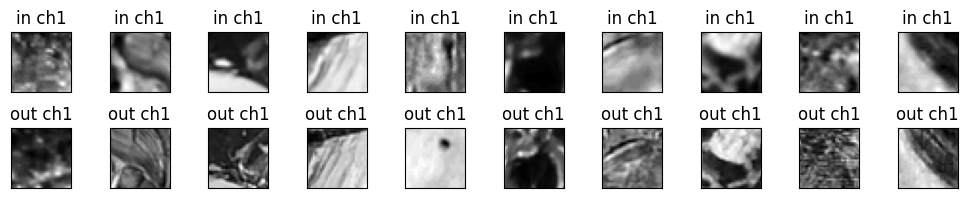

In [ ]:
import matplotlib.pyplot as plt

N = 2000
n = 10
plt.figure(figsize=(10, 4))

for i in range(n):
    ax = plt.subplot(4, n, i + 1)
    plt.title("in ch1")
    plt.imshow(train_input[i + N][:,:,0], cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(4, n, i + n + 1)
    plt.title("out ch1")
    plt.imshow(train_output[i + N][:,:,0], cmap='gray')
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


## Creating the Unet model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from tensorflow.keras import layers, losses
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_shape=(size, size, 1)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', strides = 2)(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', strides = 2)(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    #conv4 = Conv2D(512, 3, activation='relu', padding='same', strides = 2)(conv3)
    #conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    #conv5 = concatenate([Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same')(conv4), conv3], axis = -1)
    #conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    conv6 = concatenate([Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same')(conv3), conv2], axis = -1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    conv7 = concatenate([Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same')(conv6), conv1], axis = -1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output Layer
    output = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Usage example:
unet = unet_model()
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 16, 16, 128)          73856     ['conv2d_1[0][0]']            
                                                                                              

## Training the Unet model

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
unet.compile(optimizer=opt, loss=losses.MeanSquaredError())
start = time.time()
model = unet.fit(train_input, train_output,
                epochs=100,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=16)
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet.save(file_path + 'Model/unet_' + str(model_number) + '_L')

loss = model.history['loss']
loss = pd.DataFrame(loss)
loss.to_csv(file_path + 'Model/loss_'+ str(model_number) + '_L.csv')
val_loss = model.history['val_loss']
val_loss = pd.DataFrame(val_loss)
val_loss.to_csv(file_path  +'Model/val_loss_'+ str(model_number)+ '_L.csv')

Epoch 1/100
1757/1757 [==============================] - 33s 13ms/step - loss: 0.0201 - val_loss: 0.0180
Epoch 2/100
1757/1757 [==============================] - 23s 13ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 3/100
1757/1757 [==============================] - 23s 13ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 4/100
1757/1757 [==============================] - 23s 13ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 5/100
1757/1757 [==============================] - 22s 13ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 6/100
1757/1757 [==============================] - 23s 13ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 7/100
1757/1757 [==============================] - 22s 13ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 8/100
1757/1757 [==============================] - 22s 13ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 9/100
1757/1757 [==============================] - 23s 13ms/step - loss: 0.0141 - val_loss: 0.0149
Epoch 10/100
1757/1757 [==============================]

## Testing the model

2/2 [==============================] - 0s 12ms/step


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x78dfe48ab4f0>)

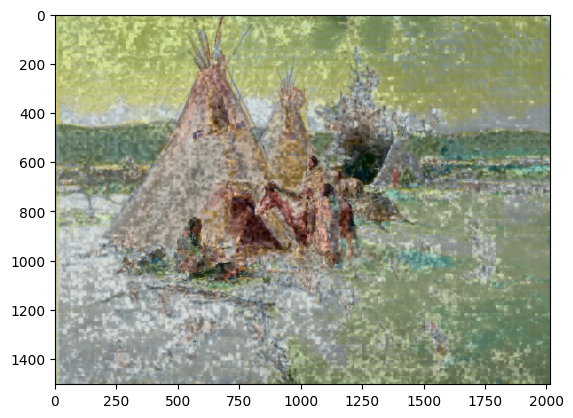

In [28]:
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876

n_size = 32
size = 32

def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

def L_AB_rgb_unnormalized(ab_image, final_L):
    ab_image = ab_image/255.0
    final_L = final_L/255.0
    final_L[..., 0] = final_L[..., 0]*100.0
    ab_image[..., 0] = (ab_image[..., 0] * 255.0) - 128
    ab_image[..., 1] = (ab_image[..., 1] * 255.0) - 128
    LAB_array = np.dstack((final_L, ab_image[:,:,0], ab_image[:,:,1]))
    rgb_array_unnormalized = color.lab2rgb(LAB_array)# Convert LAB to RGB colorspace
    rgb_array_unnormalized = (rgb_array_unnormalized * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_image_unnormalized = Image.fromarray(rgb_array_unnormalized, mode='RGB')# Convert RGB array back to image
    return rgb_image_unnormalized

def crop_(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            data.append(im1)
    return data


#----------------READING THE TEST IMAGE--------------------#
filename = str("INPUT_[09] Preserve and Protect.png")
test = Image.open(file_path+ "Testing/" + filename).convert('RGB')
test = rgb_lab_normalized(test)
w_dirty, h_dirty = test.size
#----------------------------------------------------------#


#----------------GETTING AB--------------------#
autoencoder = keras.models.load_model(file_path + 'Model/unet_'+str(n_size)+'_ab')

xx = int(w_dirty/n_size)
final=[]
for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    neverbeforeseen = neverbeforeseen[:,:,:,1:3]
    neverbeforeseen = np.array(neverbeforeseen).astype(np.float32)/255.0
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))

#----------------GETTING L--------------------#
autoencoder = keras.models.load_model(file_path + 'Model/unet_'+str(n_size)+'_L')

final_L=[]
for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    neverbeforeseen = neverbeforeseen[:,:,:,0:1]
    neverbeforeseen = np.array(neverbeforeseen).astype(np.float32)/255.0
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final_L = y
    if portion > 0:
        final_L = np.hstack((final_L,y))

#----------------TEST ON L from model and AB from model--------------------#
final_L_AB = L_AB_rgb_unnormalized(final, final_L)
final_L_AB = np.squeeze(final_L_AB)
reconstructed_L_AB = Image.fromarray(final_L_AB)
reconstructed_L_AB.save(file_path + "Testing/"+"CLEAN"+str(size)+"_L_AB_"+filename)
plt.figure(), plt.imshow(reconstructed_L_AB)